# 재무제표를 이용한 분석

In [23]:
import pandas as pd
import datetime
import time
import requests
import numpy as np

start = time.time()
df_jongmok = pd.read_csv("./csv/jongmok_list.csv", encoding="euc-kr")[["단축코드", "한글 종목약명"]]
df_jongmok = df_jongmok.rename(columns={"단축코드":"CD", "한글 종목약명":"NM"})
# 데이터 프레임에 적용할 컬럼 정의
list_columns = [
    "DT", "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME", "FRGN_RT", "END_PRC", "VOL", "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN",
]
list_balance = [
    "CD", "NM", "ROE", "PER", "PBR", "PROFIT", "INCOME"
]
list_day_summary = [
    "DT", "CD", "NM", "FRGN_RT", "END_PRC", "VOL", "PRC_AVG_5", "PRC_VOL_5", "PRC_AVG_10", "PRC_VOL_10", "PRC_MEDIAN", "VOL_MEDIAN",
]


list_result = []
list_no_data = []
dt = datetime.datetime.now().strftime("%Y-%m-%d")

def get_day_info(cd, nm):
    # 그룹 함수 적용
    def get_grouped(df_base):
        grouped = df_base.groupby(["NM"]).agg({
            "종가": "mean", "거래량": "mean",
        })
        grouped.columns = ["PRC_AVG", "VOL_AVG",]
        grouped = grouped.reset_index()

        return grouped
    
    pg = 1
    headers = {
        "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
        "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
    }
    
    url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
    res = requests.get(url=url, headers=headers)      
    # Pandas : read_html() > table element 추출 가능
    df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()
    end_prc = int(df_data.iloc[0][1])
    vol = df_data.iloc[0][6]
    df_data["NM"] = nm
    # 5일평균, 10일 평균, 중위값,
    # prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median
    # 5일 평균
    df_grouped = get_grouped(df_data.head(5))
    prc_avg_5 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_5 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 10일 평균
    df_grouped = get_grouped(df_data)
    prc_avg_10 = float(str(df_grouped["PRC_AVG"].iloc[0]))
    vol_avg_10 = float(str(df_grouped["VOL_AVG"].iloc[0]))
    # 중앙 값
    prc_median = np.median(list(df_data["종가"]))
    vol_median = np.median(list(df_data["거래량"]))
    
    return end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median


# ROE 값이 기준값 이상인 것만 고른다
def get_roe_more_than_base(cd, nm):
    roe_base = 15.0
    url = f"https://finance.naver.com/item/main.naver?code={cd}"
    
    list_roe = []
    list_per = []
    list_pbr = []
    list_profit = []
    list_income = []
    
    try:
        list_df = pd.read_html(url, encoding="euc-kr")
        df_bs_sheet = list_df[3]
        
        roe = 0.0
        
        if ".03" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.03"][0])
            list_ym = ["2019.03","2020.03","2021.03"]
        elif ".06" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
            list_ym = ["2019.06","2020.06","2021.06"]
        elif ".09" in str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]:
            roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.09"][0])
            list_ym = ["2019.09","2020.09","2021.09"]
        else:
            try:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
                list_ym = ["2018.12","2019.12","2020.12","2021.12(E)"]
            except:
                roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
                list_ym = ["2019.12","2020.12","2021.12"]
    
        if roe >= roe_base:
            # 일 거래 종합
            end_prc, vol, prc_avg_5, vol_avg_5, prc_avg_10, vol_avg_10, prc_median, vol_median = get_day_info(cd, nm)
            # 거래량
            list_deal_vol = list_df[0][2][0].split(" ")
            deal_volume = list_deal_vol[len(list_deal_vol)-1].replace(",","")
            # 외국인
            frgn_rt = float(list_df[6][1].iloc[2].replace("%", ""))
            # 데이터 생성
            for ym in list_ym:
                try:
                    list_roe.append(float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", ym][0]))
                    list_per.append(float(df_bs_sheet.fillna(0).iloc[10].loc["최근 연간 실적", ym][0]))
                    list_pbr.append(float(df_bs_sheet.fillna(0).iloc[12].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.fillna(0).iloc[1].loc["최근 연간 실적", ym][0]) is str:
                        list_profit.append(int(df_bs_sheet.fillna(0).iloc[1].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_profit.append(int(df_bs_sheet.fillna(0).iloc[1].loc["최근 연간 실적", ym][0]))
                    if type(df_bs_sheet.fillna(0).iloc[2].loc["최근 연간 실적", ym][0]) is str:
                        list_income.append(int(df_bs_sheet.fillna(0).iloc[2].loc["최근 연간 실적", ym][0].replace(",", "")))
                    else:
                        list_income.append(int(df_bs_sheet.fillna(0).iloc[2].loc["최근 연간 실적", ym][0]))
                except:
                    list_roe.append(0)
                    list_per.append(0)
                    list_pbr.append(0)
                    list_profit.append(0)
                    list_income.append(0)
            
            list_result.append([dt, "A" + cd, nm, 
                                list_roe, list_per, list_pbr, list_profit, list_income, 
                                frgn_rt, int(end_prc), int(vol), int(prc_avg_5), int(vol_avg_5), int(prc_avg_10), int(vol_avg_10), int(prc_median), int(vol_median),
                               ])
    except Exception as e:
        list_no_data.append([cd, nm, e])
        
# get_roe_more_than_base("005880", "삼성")
for index, row in df_jongmok.iterrows():
    get_roe_more_than_base(str(row.CD), row.NM)

# Today's dataframe
df_now = pd.DataFrame(data=list_result, columns=list_columns)
df_now[list_balance].to_csv("./csv/balance_sheet.csv", encoding="utf-8-sig", index=False)
# Day Summary Possesion
try:
    # Extract from yesterday csv file and make dataframe
    df_pre = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
    df_result = pd.concat([df_now[list_day_summary], df_pre]).drop_duplicates()
    # Save result dataframe to csv file 
    df_result.to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)
# No previous data
except:
    df_now[list_day_summary].to_csv("./csv/day_summary.csv", encoding="utf-8-sig", index=False)
    
end = time.time()

print("#" * 100)
df_no_data = pd.DataFrame(data=list_no_data, columns=["CD", "NM", "MESSAGE"])
df_no_data.to_csv("./csv/no_data.csv", encoding="utf-8-sig", index=False)
print(f"Elapsed Seconds: {end - start}")

/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_12041/1630944393.py:95: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12(E)"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_12041/1630944393.py:88: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.06"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_12041/1630944393.py:98: PerformanceWarning: indexing past lexsort depth may impact performance.
  roe = float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", "2021.12"][0])
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_12041/1630944393.py:112: PerformanceWarning: indexing past lexsort depth may impact performance.
  list_roe.append(float(df_bs_sheet.fillna(0).iloc[5].loc["최근 연간 실적", ym][0]))
/var/folders/l2/31k7fcdd2xb41np3rpzw20lh0000gn/T/ipykernel_12041/1630944

####################################################################################################
Elapsed Seconds: 414.5026578903198


In [24]:
import pandas as pd

# 외국인 보유비율
df_frgn_rt = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
df_sorted_frgn = df_frgn_rt.sort_values(by=["CD", "DT"])
# 최근 20일 외국인 보유
list_nm = df_sorted_frgn["NM"].unique()
dict_frgn_rt = {}
for nm in list_nm:
    dict_frgn_rt[nm] = list(df_sorted_frgn[df_sorted_frgn["NM"] == nm][["NM", "FRGN_RT"]].head(20).T.reset_index().loc[1])[1:]
    
df_frgn_rt_calc = df_sorted_frgn.groupby(["NM"]).agg(
    FIRST_RT=("FRGN_RT", "first"), 
    LAST_RT=("FRGN_RT", "last")).reset_index()

df_frgn_rt_calc["GAP"] = df_frgn_rt_calc["LAST_RT"] - df_frgn_rt_calc["FIRST_RT"]
df_frgn_rt_calc["GAP_RT"] = round((df_frgn_rt_calc["GAP"] / df_frgn_rt_calc["FIRST_RT"]) * 100, 2)

df_frgn_rt_calc.sort_values(by=["GAP_RT"], ascending=False).fillna(0.0)

,NM,FIRST_RT,LAST_RT,GAP,GAP_RT
0,BGF리테일,30.90,30.90,0.0,0.0
184,코오롱글로벌,1.90,1.90,0.0,0.0
156,이엠넷,25.52,25.52,0.0,0.0
157,이엠텍,5.62,5.62,0.0,0.0
158,이오테크닉스,15.61,15.61,0.0,0.0
...,...,...,...,...,...
245,휴온스,21.93,21.93,0.0,0.0
17,KG동부제철우,0.00,0.00,0.0,0.0
36,SBS,0.00,0.00,0.0,0.0
52,금호건설우,0.00,0.00,0.0,0.0


In [25]:
# 거래량
df_deal_vol = pd.read_csv("./csv/day_summary.csv", encoding="utf-8-sig")
df_sorted = df_deal_vol.sort_values(by=["CD", "DT"])
# 최근 20일 외국인 보유
list_nm = df_sorted["NM"].unique()
dict_deal_vol = {}
for nm in list_nm:
    dict_deal_vol[nm] = list(df_sorted[df_sorted["NM"] == nm][["NM", "VOL"]].head(5).T.reset_index().loc[1])[1:]
    
df_deal_vol_calc = df_sorted.groupby(["NM"]).agg(
    FIRST_RT=("VOL", "first"), 
    LAST_RT=("VOL", "last")).reset_index()
    
df_deal_vol_calc["GAP"] = df_deal_vol_calc["LAST_RT"] - df_deal_vol_calc["FIRST_RT"]
df_deal_vol_calc["GAP_RT"] = round((df_deal_vol_calc["GAP"] / df_deal_vol_calc["FIRST_RT"]) * 100, 2)

df_deal_vol_calc.sort_values(by=["GAP_RT"], ascending=False).fillna(0.0)

,NM,FIRST_RT,LAST_RT,GAP,GAP_RT
0,BGF리테일,41023,41023,0,0.0
184,코오롱글로벌,39953,39953,0,0.0
156,이엠넷,49444,49444,0,0.0
157,이엠텍,90908,90908,0,0.0
158,이오테크닉스,63033,63033,0,0.0
...,...,...,...,...,...
88,리노공업,40963,40963,0,0.0
245,휴온스,48817,48817,0,0.0
116,스포츠서울,0,0,0,0.0
138,오스템임플란트,0,0,0,0.0


In [26]:
# 재무제표 선정 종목
df_balance = pd.read_csv("./csv/balance_sheet.csv", encoding="utf-8-sig")
# 대상 종목의 외국인 추세 추가
df_balance["FRGN_RT"] = df_balance["NM"].apply(lambda X: dict_frgn_rt[X])
df_balance["VOL"] = df_balance["NM"].apply(lambda X: dict_deal_vol[X])
df_balance

,CD,NM,ROE,PER,PBR,PROFIT,INCOME,FRGN_RT,VOL
0,A282330,BGF리테일,"[26.46, 18.6, 19.61]","[19.35, 19.09, 17.03]","[4.7, 3.36, 3.11]","[1966, 1622, 1994]","[1514, 1227, 1476]",[30.9],[41023]
1,A000995,DB하이텍1우,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]",[1.07],[336]
2,A000990,DB하이텍,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]",[23.73],[641667]
3,A000215,DL우,"[12.37, 11.74, 11.84, 30.08]","[6.12, 5.25, 6.34, 1.39]","[0.73, 0.59, 1.24, 0.4]","[8454, 1360, 1190, 2476]","[6781, 7103, 5727, 9232]",[7.2],[527]
4,A001880,DL건설,"[23.04, 23.71, 19.95]","[3.17, 3.94, 3.6]","[0.66, 0.89, 0.66]","[1430, 2034, 2296]","[951, 1493, 1756]",[2.11],[32160]
...,...,...,...,...,...,...,...,...,...
241,A298020,효성티앤씨,"[20.86, 25.1, 76.22]","[7.18, 6.68, 2.93]","[1.36, 1.52, 1.58]","[3229, 2666, 14237]","[1220, 1683, 10079]",[12.04],[48707]
242,A298000,효성화학,"[21.37, -2.71, 15.58]","[5.25, -42.98, 13.75]","[1.01, 1.24, 1.92]","[1539, 609, 1486]","[878, -116, 704]",[7.29],[23289]
243,A081660,휠라홀딩스,"[16.03, 23.8, 10.94, 18.63]","[22.78, 12.14, 19.11, 7.23]","[3.3, 2.58, 2.03, 1.21]","[3571, 4707, 3411, 5193]","[2100, 3381, 1977, 3685]",[41.54],[281147]
244,A205470,휴마시스,"[-7.82, 0.0, 120.63]","[-31.81, 14.8, 3.78]","[2.57, 6.67, 2.83]","[-9, 254, 1936]","[-12, 209, 1512]",[5.28],[1425561]


In [29]:
# ROE 증가 여부 추가
def check_rising_list_val(col):
    list_roe = eval(col)
    
    if len(list_roe) < 2:
        return "N"
    
    pre_roe = 0
    for roe in list_roe:
        if pre_roe == 0:
            pre_roe = roe
            continue
        elif roe < pre_roe:
            return "N"
            
    return "Y"

# rising_roe = check_rising_list_val("[17.12, 17.39, 23.07, 31.18]")
# print(rising_roe)
df_balance["RISING_ROE"] = df_balance["ROE"].apply(lambda X: check_rising_list_val(X))
df_balance["RISING_PROFIT"] = df_balance["PROFIT"].apply(lambda X: check_rising_list_val(X))

df_selected = df_balance[(df_balance["RISING_ROE"] == "Y") & (df_balance["RISING_PROFIT"] == "Y")]

df_selected = pd.merge(
)

,CD,NM,ROE,PER,PBR,PROFIT,INCOME,FRGN_RT,VOL,RISING_ROE,RISING_PROFIT
1,A000995,DB하이텍1우,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]",[1.07],[336],Y,Y
2,A000990,DB하이텍,"[17.12, 17.39, 23.07, 31.18]","[5.56, 11.74, 13.67, 10.61]","[0.84, 1.86, 2.79, 2.81]","[1130, 1813, 2393, 3810]","[868, 1046, 1660, 2908]",[23.73],[641667],Y,Y
8,A016385,KG동부제철우,"[-7.44, 7.18, 17.99]","[-8.37, 17.37, 5.55]","[0.88, 1.19, 0.92]","[346, 1108, 2969]","[-335, 669, 1907]",[0.0],[29],Y,Y
9,A016380,KG동부제철,"[-7.44, 7.18, 17.99]","[-8.37, 17.37, 5.55]","[0.88, 1.19, 0.92]","[346, 1108, 2969]","[-335, 669, 1907]",[1.22],[631077],Y,Y
13,A011070,LG이노텍,"[4.73, 10.2, 30.94]","[32.39, 18.29, 9.7]","[1.5, 1.78, 2.6]","[4764, 6810, 12642]","[1023, 2361, 8883]",[24.11],[472235],Y,Y
...,...,...,...,...,...,...,...,...,...,...,...
229,A001750,한양증권,"[1.73, 7.85, 14.22, 22.11]","[19.45, 4.69, 2.66, 2.24]","[0.33, 0.35, 0.35, 0.45]","[56, 296, 643, 1210]","[47, 222, 459, 870]",[8.78],[14649],Y,Y
230,A002220,한일철강,"[-6.98, -3.3, 15.87]","[-4.24, -8.81, 2.78]","[0.28, 0.29, 0.37]","[-73, -42, 296]","[-109, -48, 255]",[1.53],[264346],Y,Y
231,A066110,한프,"[-70.15, -49.12, 24.24]","[-1.83, -2.42, 8.51]","[1.53, 1.56, 1.64]","[-100, -55, -77]","[-194, -94, 82]",[0.88],[0],Y,Y
235,A195870,해성디에스,"[9.06, 13.62, 27.09]","[14.65, 13.83, 11.65]","[1.29, 1.79, 2.82]","[270, 435, 863]","[182, 300, 711]",[6.46],[82249],Y,Y


In [1]:
import seaborn as sns

In [18]:
def draw_line(nm):
    df_jongmok = df_sorted_frgn.query(f"NM == '{nm}'")
    sns.lineplot(data=df_jongmok, x="DT", y="FRGN_RT")

In [ ]:
g = sns.FacetGrid(df_sorted, col = "NM")
g.map(sns.lineplot, "DT", "FRGN_RT" )

In [ ]:
df_wide = df_sorted.pivot("DT", "NM", "FRGN_RT").reset_index()

df_wide

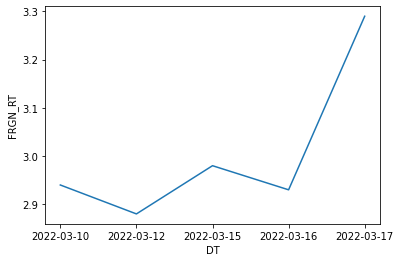

In [141]:
draw_line("에치에프알")

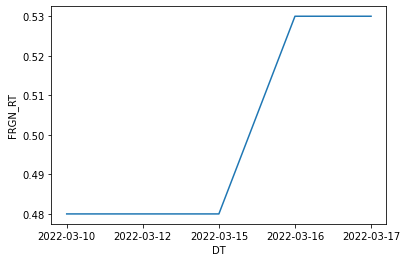

In [142]:
draw_line("레이크머티리얼즈")

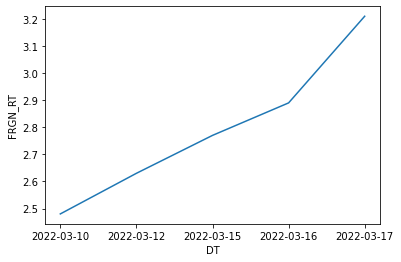

In [143]:
draw_line("KEC")

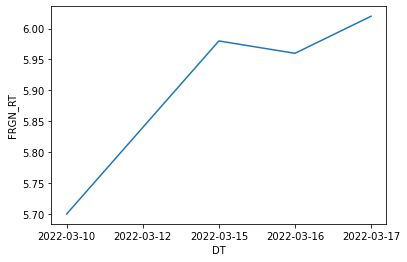

In [20]:
draw_line("대한해운")

In [32]:
url = f"https://finance.naver.com/item/sise.naver?code=263720"
    
list_df = pd.read_html(url, encoding="euc-kr")

list_df

[                    0                                        1  \
 0  전일  29,600  29,600  고가  30,75030,750  (상한가  38,45038,450  )   
 1    시가  29,75029,750        저가  29,55029,550  (하한가  20,750  )   
 
                      2  
 0  거래량  26,898  26,898  
 1   거래대금  810  810  백만  ,
           0        1       2         3
 0       현재가    30400    매도호가     30450
 1      전일대비  상승  800    매수호가     30400
 2    등락률(%)   +2.70%     전일가     29600
 3       거래량    26898      시가     29750
 4   거래대금(천)      810      고가     30750
 5       액면가     500원      저가     29550
 6       NaN      NaN     NaN       NaN
 7       상한가    38450    전일상한     36950
 8       하한가    20750    전일하한     19950
 9       PER    24.72     EPS      1230
 10   52주 최고    61900  52주 최저     28200
 11     시가총액  3,732억원   상장주식수  12275111
 12    외국인현재    123천주     자본금   6,137백만,
      매도잔량     매도호가  Unnamed: 2     매수호가    매수잔량
 0     NaN      NaN         NaN      NaN     NaN
 1   240.0  30650.0         NaN      NaN     NaN
 2   871.0

In [29]:
remain_sell = list_df[3].iloc[0][0]
remain_buy = list_df[3].iloc[0][2]

print(remain_sell, remain_buy)

3540 8958


In [125]:
import requests

cd = "005930"
pg = 1

headers = {
    "referer" : f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}",    
    "user-agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/97.0.4692.71 Safari/537.36" 
}

url = f"https://finance.naver.com/item/sise_day.naver?code={cd}&page={pg}"
res = requests.get(url=url, headers=headers)      

# Pandas : read_html() > table element 추출 가능
df_data = pd.read_html(res.text)[0].dropna().set_index("날짜").reset_index()

print(df_data.iloc[0][6])

# 5일평균, 10일 평균, 중위값,
# prc_avg_5, prc_avg_10, vol_avg_5, vol_avg_10, prc_median, vol_median

df_data["NM"] = "AAA"
grouped = df_data.groupby(["NM"]).agg({
    "종가": "mean", "거래량": "mean",
})
grouped.columns = ["PRC_AVG_10", "VOL_AVG_10",]
grouped = grouped.reset_index()
grouped

14241145.0


,NM,PRC_AVG_10,VOL_AVG_10
0,AAA,70430.0,14616470.9


In [56]:
import numpy as np

prc_median = np.median(list(df_data["종가"]))
vol_median = np.median(list(df_data["거래량"]))

print(prc_median, vol_median)

28875.0 25592.0


In [60]:
float(str(grouped["PRC_AVG_10"].iloc[0]))

29065.0

In [118]:
url = f"https://finance.naver.com/item/main.naver?code=005930"
list_df = pd.read_html(url, encoding="euc-kr")
list_df


[                    0                                        1  \
 0  전일  71,200  71,200  고가  70,90070,900  (상한가  92,50092,500  )   
 1    시가  70,60070,600        저가  70,20070,200  (하한가  49,900  )   
 
                                 2  
 0     거래량  14,241,145  14,241,145  
 1  거래대금  1,005,242  1,005,242  백만  ,
      매도상위        거래량    매수상위        거개량
 0     NaN        NaN     NaN        NaN
 1    이베스트  1923976.0    이베스트  1934154.0
 2  미래에셋증권  1675745.0    메릴린치  1531511.0
 3     골드만  1296895.0   제이피모간  1180439.0
 4    한국증권  1129122.0    한국증권  1089528.0
 5   제이피모간   875449.0  NH투자증권  1083541.0
 6  외국계추정합  2634316.0  +77634  2711950.0,
       날짜       종가        전일비        외국인         기관
 0    NaN      NaN        NaN        NaN        NaN
 1  03/18  70700.0    하향  500 -1096120.0 -1035441.0
 2  03/17  71200.0    상향  800  -355216.0  1349681.0
 3  03/16  70400.0    상향  900 -1283656.0  1152180.0
 4  03/15  69500.0    하향  700 -2206840.0  -710699.0
 5  03/14  70200.0    상향  200   548743.0 -11

In [111]:
str(df_bs_sheet["최근 연간 실적"].loc[0]).split(" ")[0]

'2019.12'